In [95]:
import datetime
from os import path
import math
import collections
import numpy as np
np.set_printoptions(formatter={'float_kind':"{:-.3e}".format})
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal as signal
import core as co
import test_data as td

In [ ]:
if td.DATA is None:
    td.set_test_data(
    data_count=20000, 
    start_time=datetime.datetime(2023, 3, 21, 12, 24).timestamp(),
    moving_av=True)

In [14]:
from IPython.display import display as disp 
from IPython.display import Markdown as md
from IPython.display import Latex as lx

## Historical Data

The format of `test_data.DATA' is `[timestamp, [[open, high, low, close], [open, high, low, close], volume]]`. The first candle is *ASK*, second is *BID*.

The candle data are measured from the moving avarage level.

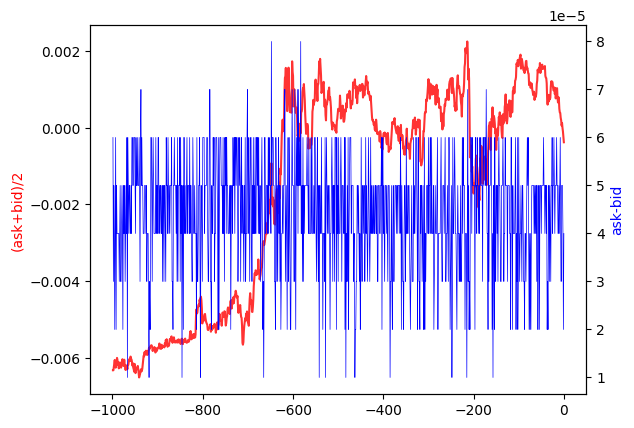

Porównanie dwóch wielkości: średniej wartości *open ask* i *open bid* 
oraz różnicy pomiędzy *ask* i *bid*.
      


In [15]:
value = td.VALUE[200: 1200]
cndl_count = np.array([i for i in range(-len(value) + 1, 1)], dtype='float64')
ask = np.array([v[0] for v in value])
bid = np.array([v[1] for v in value])

fig, mean = plt.subplots()
mean.plot(cndl_count, (ask + bid) / 2, color='red', label='ask-bid', alpha=0.8)
div = mean.twinx()
div.plot(cndl_count, ask - bid, color='blue', linewidth='0.5')
mean.set_ylabel('(ask+bid)/2', color='red')
div.set_ylabel('ask-bid', color='blue')
plt.show()

savgol_filter = co.Savgol_filter(window=50, order=3)

print('''Porównanie dwóch wielkości: średniej wartości *open ask* i *open bid* 
oraz różnicy pomiędzy *ask* i *bid*.
      ''')

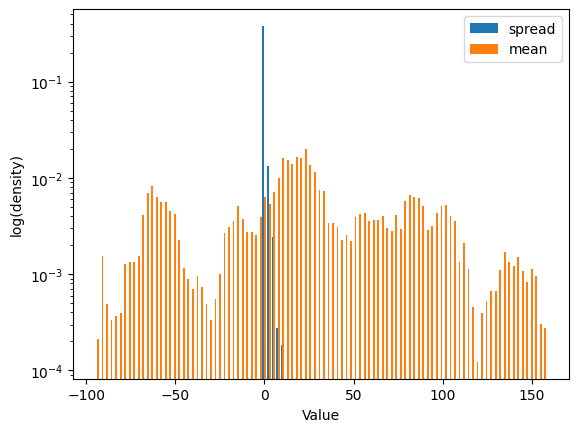

Dwa histogramy. Jeden pokazuje średnie wartości *open*, drugi - róznicę pomiędzy *ask* i *bid*.
Znaczna różnica pomiędzy szerokościami rozkładu daje nadzieję na zysk.



In [16]:
PIP = 1e-4
value = td.VALUE
ask = np.array([v[0] for v in value])
bid = np.array([v[1] for v in value])

mean = (ask + bid) / 2 / PIP
spread = (ask - bid) / PIP
plt.hist([spread, mean], bins=100, density=True, label=['spread', 'mean'])
plt.yscale('log')
plt.xlabel('Value')
plt.ylabel('log(density)')
plt.legend()
plt.show()

print('''Dwa histogramy. Jeden pokazuje średnie wartości *open*, drugi - róznicę pomiędzy *ask* i *bid*.
Znaczna różnica pomiędzy szerokościami rozkładu daje nadzieję na zysk.
''')

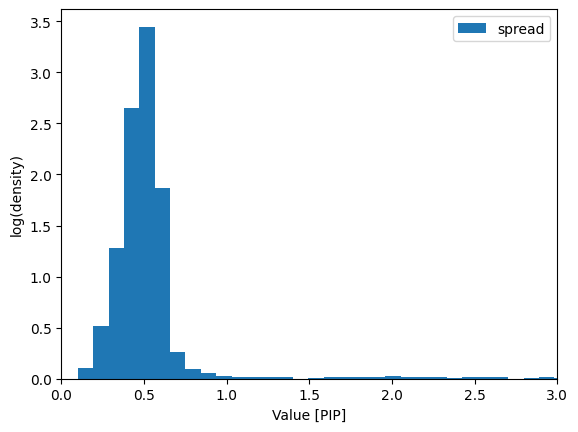

In [17]:
plt.hist(spread, bins=100, density=True, label=['spread', 'mean'])
# plt.yscale('log')
plt.xlabel('Value [PIP]')
plt.ylabel('log(density)')
plt.xlim(0, 3)
plt.legend()
plt.show()


## Klasyfikacja prognozy

* Trzy rodzaje:
    * bid
    * ask
    * wait

* Atrybuty prognozy:
    * czas zasięgu
    * czynniki paniki - czas i poziom
    * poziom transakcji

Prognoza sugeruje transakcję natychmiast, gdy zostanie przekroczony 'poziom transakcji'. Prognoza obiecuje, że cena osiągnie ten poziom w okresie 'czasu zasięgu` prognozy. Jeśli zmiany ceny nie będą monotoniczne, odchylenia od monotoniczności nie będą większe niż określone przez 'czynniki paniki'.


forecast:
direction: none


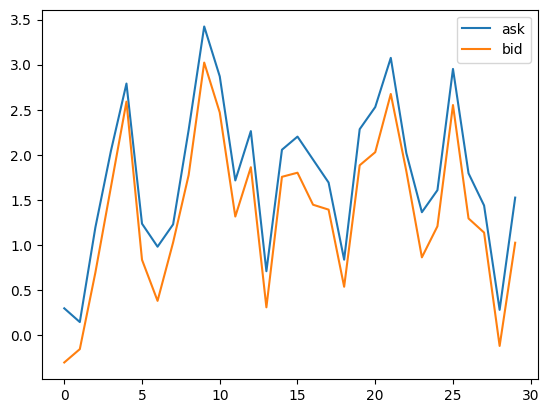

In [101]:
import importlib
import methodes as me
importlib.reload(me)
import piecewise_fit as ls
importlib.reload(ls)
importlib.reload(co)

FORECAST_WINDOW = 30
FORECAST_THRESHOLD = 2e-4 + 1e-4 # spread

shift = 200
forecast = me.Forecast(
    td.VALUE[shift: FORECAST_WINDOW + shift], 
    threshold=FORECAST_THRESHOLD)
print(forecast)
forecast.plot()


forecast:
direction: ask: sell-buy
min profit [PIP]: -3.00
panic value [PIP]: 0.00



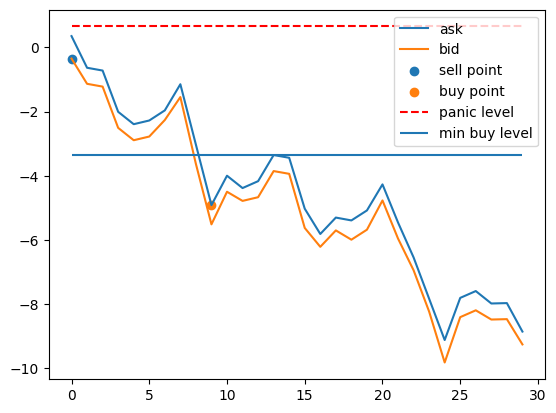

In [19]:
# shift = 1400 # below threshold
shift = 1600
forecast = me.Forecast(
    td.VALUE[shift: FORECAST_WINDOW + shift], 
    threshold=FORECAST_THRESHOLD, plotall=True)
print(forecast)
forecast.plot()

## Kompresja danych historycznych

Dane historyczne zasilają sieć neuronową mającą klasyfikować je pod względem prognozy przyszłej ewolucji. Skuteczna - to znaczy odpowiadająca moim oczekiwaniom - klasyfikacja jest - chyba - łatwiejsza gdy jest mniej w tych danych wątków od innych kategoryzacji. Chcę więc usunąć część tego szumu informacyjnego. 

Ponadto, sieć neuronowa nigdy nie osiąga bezwzględnego optimum treningu, zawsze kończy trening w jakimś lokalnym minimum. Pomniejszenie objętości danych zasilających sieć predko powieksza szansę na osiągnięcie lepszego przybliżenia optimum.

Kompresja polega na usunięciu szybko-zmiennej części spektrum danych i - następnie - kwantyzacji wartości danych.

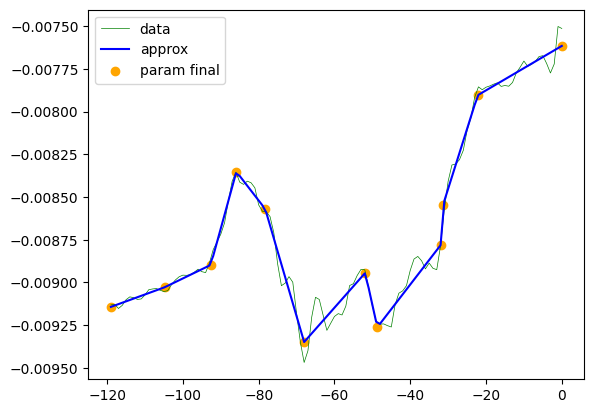


A piece of forex data is approximated piecewise with lines (or vectors). 
The approximation is of the least squares method.


In [20]:
NUMDER_PIECES = 10
WINDOW = 120
SHIFT = 0
VALUE = [_[0] for _ in td.VALUE][SHIFT: WINDOW + SHIFT]

value = co.Savgol_filter(window=15, order=8).filter(VALUE)
clazz = ls.piecewise(value, filter=None, number_pieces=NUMDER_PIECES, k=1)

cndl_count = np.arange(-len(value) + 1, 1)
plt.plot(cndl_count, value, color='green', label='data', linewidth='0.5')
plt.plot(cndl_count, clazz.approx(cndl_count), color='blue', label='approx')
plt.scatter(*clazz.knots(), color='orange', label='param final')

plt.legend()
plt.show()

disp(md('''
A piece of forex data is approximated piecewise with lines (or vectors). 
The approximation is of the least squares method.
'''))


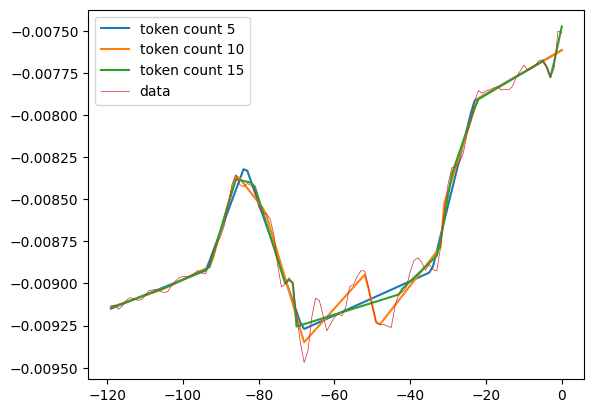

In [21]:
%matplotlib inline
fig = plt.figure()

value = co.Savgol_filter(window=15, order=8).filter(VALUE)
cndl_count = np.arange(-len(value) + 1, 1)
for n in [5, 10, 15]:
    clazz = ls.piecewise(value, filter=None, number_pieces=n)   
    plt.plot(cndl_count, clazz.approx(cndl_count), label=f'token count {n}')

plt.plot(cndl_count, value, label='data', linewidth='0.5')
plt.legend()
plt.show()

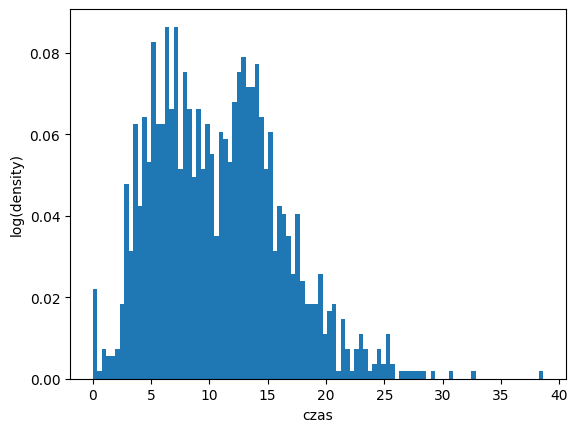

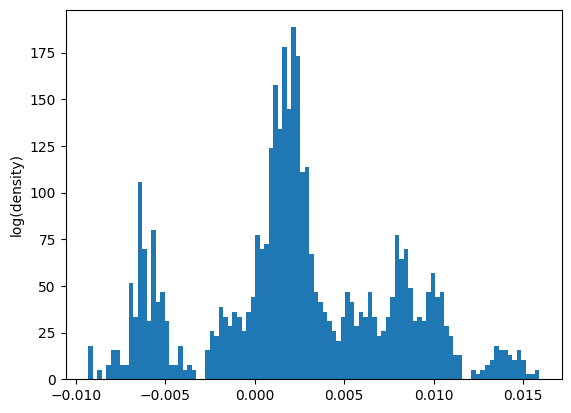

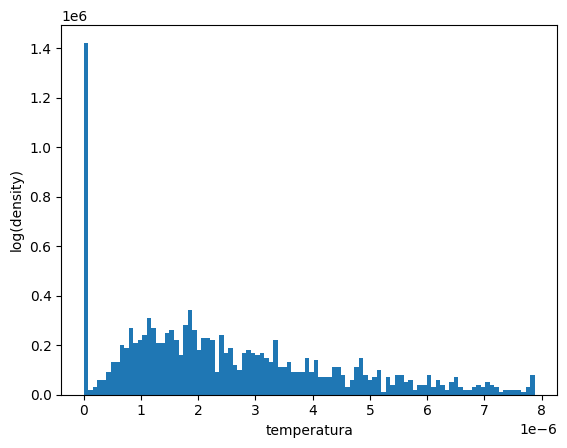


Trzy histogramy:
    * składowa czasowa wektorów wykresu,
    * składowa wartości,
    * natężenie fluktuacji.


In [22]:
window = 120
shift = 0
step = 100
time = []
level = []
temperature = []

while shift + window < len(td.VALUE):
    clazz = ls.piecewise(
        value=[(_[0] + _[1]) / 2 for _ in td.VALUE[shift: shift + window]], 
        filter=co.Savgol_filter(window=50, order=5), 
        number_pieces=NUMDER_PIECES, k=1)
    xk, yk = clazz.knots()
    time.extend(np.diff(xk))
    level.extend(yk)
    temperature.extend(clazz.temperature())
    shift += step

plt.hist(time, bins=100, density=True)
plt.xlabel('czas')
plt.ylabel('log(density)')
plt.show()

plt.hist(level, bins=100, density=True)
plt.ylabel('log(density)')
plt.show()

temperature.sort()
plt.hist(temperature[:int((1 - 0.1) * len(temperature))], bins=100, density=True)
plt.xlabel('temperatura')
plt.ylabel('log(density)')
plt.show()


disp(md('''
Trzy histogramy:
    * składowa czasowa wektorów wykresu,
    * składowa wartości,
    * natężenie fluktuacji.
'''))


## Wszystko razem

In [93]:
td.set_test_data(
    data_count=None, 
    moving_av=True)

tokenizer = me.Tokenizer(td.VALUE)
tokenizer.set_quantization_limits() 
shift = 0
window = 120 
time_temp_value = []
while shift + window < len(td.VALUE):
    time_temp_value.extend(tokenizer.get_sentence(td.VALUE[shift: shift + window]))
    shift += window

Test data size (flats are duducted) is 677512
Test data start time is 2023:01:03 21:34
Test data end time is   2024:10:25 19:00
Subtracting moving avarage: True


In [ ]:
words = collections.Counter(me.Tokenizer.get_sentence_str(time_temp_value)).most_common()
with open(
    path.join(co.DATA_STORE, f'words_{me.Tokenizer.window}_{me.Tokenizer.number_pieces}.txt'), 'w') as f:
    for word in words:
        f.write(f'{str(word)}\n')
        # use eval to read it to tuple

In [89]:
count = len(time_temp_value)
words = collections.Counter(me.Tokenizer.get_sentence_str(time_temp_value)).most_common()
words = [f'{_[0]}({_[1]})' for _ in words if _[1] > 0.05 * count]
tc = len(me.Tokenizer.time_qizer.levels)
vc = 2 * len(me.Tokenizer.value_qizer.levels)
rc = len(me.Tokenizer.temperature_qizer.levels)
print('''The format of words is "tpvv" where "t" is the time length level, 
"p" is the temperature and "vv" digits are value level: the first digit 
denotes the sign - positive if "0".''')
print(f'''The vcabulary has {tc} * {rc} * {vc} = {tc * vc * rc} words, yet only {len(words)} words used frequently:\n''', 
      words)


The format of words is "tpvv" where "t" is the time length level, 
"p" is the temperature and "vv" digits are value level: the first digit 
denotes the sign - positive if "0".
The vcabulary has 8 * 8 * 16 = 1024 words, yet only 150 words used frequently:
 ['6516(1736)', '6506(1617)', '6606(1412)', '6616(1355)', '6505(1334)', '6515(1268)', '6605(1105)', '6607(1054)', '6615(981)', '6617(968)', '5516(886)', '6507(880)', '6517(867)', '6416(838)', '7516(790)', '5506(780)', '6504(740)', '6406(715)', '6514(707)', '6405(704)', '5616(703)', '7506(678)', '7616(660)', '5505(646)', '5606(631)', '7606(617)', '6604(609)', '5515(605)', '6415(590)', '7505(573)', '7515(572)', '5605(520)', '6614(510)', '5517(503)', '5416(502)', '7605(480)', '5507(470)', '7615(466)', '5406(463)', '5615(458)', '5607(449)', '7617(448)', '6513(442)', '5617(434)', '7607(423)', '6707(417)', '7507(414)', '5405(408)', '6717(405)', '6716(403)', '6706(403)', '6503(399)', '5504(398)', '6414(397)', '7517(378)', '5514(372)', '6407(3

current sequence:
 ['6505', '6405', '6505', '6505', '6505', '5505', '6605', '6605', '6605', '5505', '7505']
time part:
 ['1.07e+01', '7.59e+00', '8.06e+00', '1.31e+01', '1.11e+01', '6.40e+00', '1.06e+01', '1.29e+01', '1.01e+01', '6.57e+00', '2.18e+01']
temperature part:
 ['8.07e-05', '6.85e-05', '1.25e-04', '1.26e-04', '1.38e-04', '1.15e-04', '2.77e-04', '1.61e-04', '1.51e-04', '1.26e-04', '8.53e-05']
value part:
 ['3.49e-03', '3.21e-03', '3.03e-03', '2.97e-03', '2.72e-03', '2.44e-03', '2.37e-03', '2.21e-03', '2.38e-03', '2.72e-03', '2.80e-03']


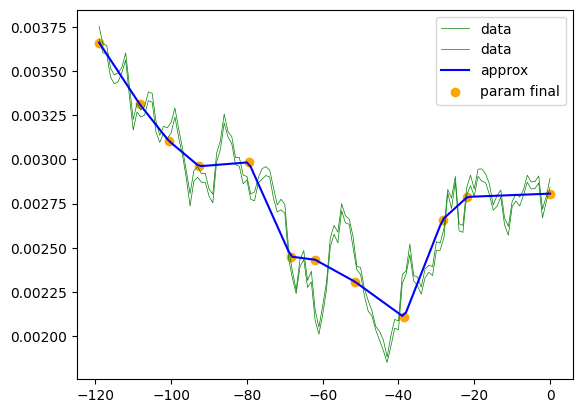

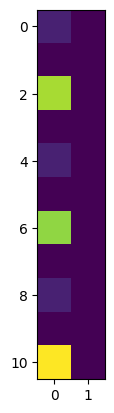

forecast:
direction: ask: sell-buy
min profit [PIP]: -3.00
panic value [PIP]: 0.00



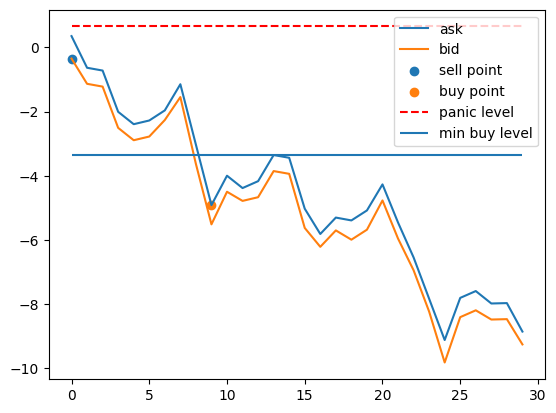

In [ ]:
from PIL import Image
from matplotlib.pyplot import imshow

window = 120
shift = 1600
value = td.VALUE[shift: window + shift] 
time_temp_value = tokenizer.get_sentence(value)

print('current sequence:\n', me.Tokenizer.get_sentence_str(time_temp_value))
print('time part:\n', [f'{_:.2e}' for _ in tokenizer.time_part])
print('temperature part:\n', [f'{_:.2e}' for _ in tokenizer.temp_part])
print('value part:\n', [f'{_:.2e}' for _ in tokenizer.value_part])
      
me.Tokenizer.number_pieces = 10     
bytes = me.Tokenizer.get_sentence_bytes(time_temp_value)

cndl_count = np.arange(-len(value) + 1, 1)
plt.plot(cndl_count, value, color='green', label='data', linewidth='0.5')
plt.plot(cndl_count, tokenizer.clazz.approx(cndl_count), color='blue', label='approx')
plt.scatter(*tokenizer.clazz.knots(), color='orange', label='param final')

plt.legend()
plt.show()
# print(bytes.hex())
h = 2
w = 11

bytes = np.flip(np.array(bytes)).copy(order='C')
img = Image.frombytes("L", (h, w), bytes) 
imshow(np.asarray(img))
plt.show()

forecast = me.Forecast(
    td.VALUE[shift: FORECAST_WINDOW + shift], 
    threshold=FORECAST_THRESHOLD, plotall=True)
print(forecast)
forecast.plot() 

[  4  16  64  16   8  16   8  16  32   2  80   4   4   8  64   1  80   8
  96   8 128  16]


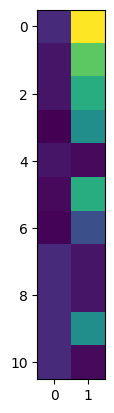

In [ ]:
print(np.array(bytes))
# print(np.flip(np.array(bytes)))
# bytes.flags
bytes = np.flip(np.array(bytes)).copy(order='C')
# bytes = bytes.copy(order='C')
# bytes.flags
# bytes = np.flip(np.array(bytes).copy(order='C'))
img = Image.frombytes("L", (h, w), bytes)
imshow(np.asarray(img))
plt.show()